#  Anomaly Detection for Quality Control

## Imports

In [1]:
import os
import random

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchinfo import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from pathlib import Path

from skimage.metrics import structural_similarity as ski_ssim
from pytorch_msssim import SSIM, MS_SSIM

# Setup device to GPU if possible
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Dataset select

Neural network will be trained on one of the MVTec available subsets. For this example, "capsule" dataset have been selected.

In [2]:
dataset_name = 'capsule' # Selected dataset contained in "data/" directory

train_dir = Path(f"data/{dataset_name}/train")
test_dir = Path(f"data/{dataset_name}/test")

## Parameters

In [3]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32
IMG_RESIZE = 256     # Resize of an input images
INPUT_CROP  = 256    # Crop of resized images (when equal to IMG_RESIZE value, there is no crop applied)
TRAINING_SIZE = 1000 # Number of images taken for training
TEST_SIZE = 100      # Number of images taken for testing

## Subdirectories viewer

In [4]:
def explore_dir(dir_path):
    """
    Function for exploring specified directory dependencies and number of images
    
    Args:
        dir_path (str or Path): Location of interested directory   
    """
    for current_dir, dirs, img in os.walk(dir_path):
        print(f"'{current_dir}' have {len(dirs)} directories and {len(img)} images.")
    print("")

explore_dir(train_dir)
explore_dir(test_dir)

'data\capsule\train' have 1 directories and 0 images.
'data\capsule\train\good' have 0 directories and 219 images.

'data\capsule\test' have 6 directories and 0 images.
'data\capsule\test\crack' have 0 directories and 23 images.
'data\capsule\test\faulty_imprint' have 0 directories and 22 images.
'data\capsule\test\good' have 0 directories and 23 images.
'data\capsule\test\poke' have 0 directories and 21 images.
'data\capsule\test\scratch' have 0 directories and 23 images.
'data\capsule\test\squeeze' have 0 directories and 20 images.



## View data

Random image path: data\capsule\test\scratch\017.png
Image size: 1000x1000


(-0.5, 999.5, 999.5, -0.5)

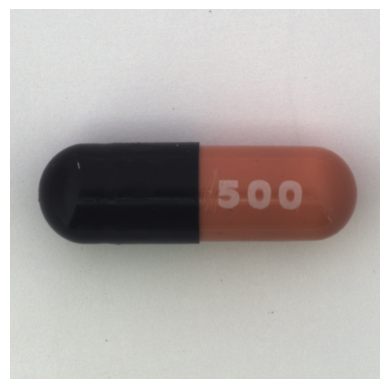

In [5]:
images_paths = list(test_dir.glob("*/*.png")) # Gets list of all images paths from given directory
random_image_path = random.choice(images_paths)
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image size: {img.height}x{img.width}") 

fig, ax = plt.subplots(1, 1)
plt.gray()
ax.imshow(img)
ax.axis("off")

## Data augmentation

In [6]:
data_transform = transforms.Compose([
    transforms.Resize(size=(IMG_RESIZE, IMG_RESIZE)),
    transforms.Grayscale(1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()])

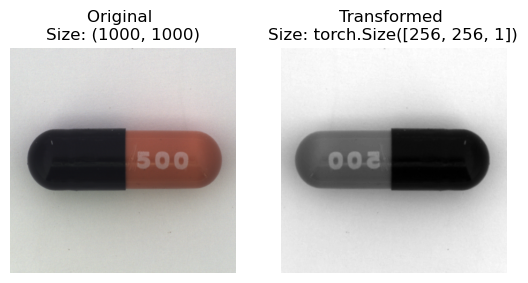

In [7]:
def image_transformation_plot(image_path, transform):
    """
    Plots and compares selected image before and after transformation.
    
    Args:
        image_path (Path): Path of image to plot
        transform (Pytorch Transforms): Selected transforms composition
    """
    f = Image.open(image_path)
    
    fig, ax = plt.subplots(1, 2)
    plt.gray()
    ax[0].imshow(f) 
    ax[0].set_title(f"Original \nSize: {f.size}")
    ax[0].axis("off")
    
    transformed_image = transform(f).permute(1, 2, 0) 
    ax[1].imshow(transformed_image) 
    ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
    ax[1].axis("off")

image_transformation_plot(random_image_path, data_transform)

## Train and test datasets preparation

Custom train/test dataset preparation function have been written to control datasets size and enable pictures crop.

In [8]:
def random_crop(data_dir, N, crop):
    """
    Function for building dataset with randomly choosen images with applied random crop to  size.
    
    Args:
        data_dir (str or Path): Location of interested directory
        N (int): Number of images in prepared dataset
        
    Returns:
        output_dataset (list): A list of cropped images
    """
    crop_size = (crop, crop)

    output_dataset = []

    images_paths = list(data_dir.glob("good/*.png"))

    for i in range(0, N):
        random_image_path = random.choice(images_paths)
        img = Image.open(random_image_path)
        img = data_transform(img).squeeze(0)
        
        x_start = random.randint(0, img.shape[0]-crop_size[0])
        y_start = random.randint(0, img.shape[1]-crop_size[1])
        x_end = x_start + crop_size[0]
        y_end = y_start + crop_size[1]
        
        crop = img[x_start:x_end, y_start:y_end]
        crop = crop.type(torch.float32).unsqueeze(0)
        output_dataset.append(crop)

    return output_dataset

In [9]:
train_data = random_crop(data_dir=train_dir, N=TRAINING_SIZE, crop = INPUT_CROP)

test_data = random_crop(data_dir=test_dir, N=TEST_SIZE, crop = INPUT_CROP)

print(f"Image tensor:\n{test_data[0][0]}")
print(f"Image shape: {test_data[0][0].shape}")
print(f"Image datatype: {test_data[0][0].dtype}")

Image tensor:
tensor([[0.8039, 0.8039, 0.8118,  ..., 0.8510, 0.8510, 0.8471],
        [0.8000, 0.8039, 0.8118,  ..., 0.8471, 0.8510, 0.8471],
        [0.8078, 0.8039, 0.8078,  ..., 0.8471, 0.8510, 0.8431],
        ...,
        [0.8471, 0.8510, 0.8549,  ..., 0.8510, 0.8471, 0.8314],
        [0.8471, 0.8510, 0.8549,  ..., 0.8510, 0.8510, 0.8510],
        [0.8431, 0.8431, 0.8510,  ..., 0.8549, 0.8549, 0.8549]])
Image shape: torch.Size([256, 256])
Image datatype: torch.float32


## Dataloader

In [10]:
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, 
                              num_workers=NUM_WORKERS, 
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False)

# Check if the input values are in <0,1> range to define activation function or normalize
images = next(iter(train_dataloader))
print(f"Image shape: {images.shape}\n {torch.min(images)}\n {torch.max(images)}")

Image shape: torch.Size([32, 1, 256, 256])
 0.05098039284348488
 0.9764705896377563


## Model

In [11]:
class autoencoder_v0(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        
        self.encoder = nn.Sequential( 
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d( 32, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d( 64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d( 128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d( 64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d( 128, 500, 3, stride=1, padding=0)
        )

        self.decoder = nn.Sequential(

            nn.ConvTranspose2d(500, 128, 3, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d( 64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d( 128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d( 64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d( 32, 1, 4, stride=2, padding=1),
            nn.Sigmoid()
        )
        
    
    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
     
model = autoencoder_v0()

summary(model, input_size=[BATCH_SIZE, 1, INPUT_CROP, INPUT_CROP])

Layer (type:depth-idx)                   Output Shape              Param #
autoencoder_v0                           [32, 1, 256, 256]         --
├─Sequential: 1-1                        [32, 500, 6, 6]           --
│    └─Conv2d: 2-1                       [32, 32, 128, 128]        544
│    └─ReLU: 2-2                         [32, 32, 128, 128]        --
│    └─Conv2d: 2-3                       [32, 64, 64, 64]          32,832
│    └─ReLU: 2-4                         [32, 64, 64, 64]          --
│    └─Conv2d: 2-5                       [32, 128, 32, 32]         131,200
│    └─ReLU: 2-6                         [32, 128, 32, 32]         --
│    └─Conv2d: 2-7                       [32, 64, 16, 16]          131,136
│    └─ReLU: 2-8                         [32, 64, 16, 16]          --
│    └─Conv2d: 2-9                       [32, 128, 8, 8]           131,200
│    └─ReLU: 2-10                        [32, 128, 8, 8]           --
│    └─Conv2d: 2-11                      [32, 500, 6, 6]         

## Train loop

In [12]:
def train_step(model, dataloader, loss_fn, optimizer):
    
    model.train()
    train_loss = 0
        
    for batch, img in enumerate(dataloader):
        
        img = img.to(device)
        recon = model(img)
        loss = 1 - loss_fn(recon, img)
        train_loss += loss.item() 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss = train_loss / len(dataloader)
    
    return train_loss

In [13]:
def test_step(model, dataloader, loss_fn, epoch):
    
    model.eval()
    test_loss = 0
    
    with torch.inference_mode():
        for batch, img in enumerate(dataloader):

            img = img.to(device)
            recon = model(img)
            loss = 1 - loss_fn(recon, img)
            test_loss += loss.item() 
    
        test_loss = test_loss / len(dataloader)
    
    return test_loss

In [14]:
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs):
    """
    Running train and test steps, plotting training progress and loss values.
    
    Args:
        model: Autoencoder model instance
        train_dataloader: Dataloader with training images
        test_dataloader: Dataloader with test images
        optimizer: Used optimizer - SSIM or MSE
        loss_fn: Used loss function
        epochs: Number of epochs to train the model
        
    Returns:
        results (dict): A dictionary with calculated loss values
    """
    results = {"train_loss": [], "test_loss": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer)
        
        test_loss = test_step(model=model,
                              dataloader=test_dataloader,
                              loss_fn=loss_fn,
                              epoch=epoch)
        
        train_ssim = (1 - train_loss)*100
        test_ssim = (1 - test_loss)*100
        
 
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"train_ssim: {train_ssim:.2f}% | "
              f"test_ssim: {test_ssim:.2f}% | ")

        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    return results

## Training the Model

SSIM or MSE loss functions can be set up, however better results are achieved by using SSIM, which have higher capability of capturing interdependencies between local image regions. Adam optimizer with 1e-3 learning rate is used.

In [15]:
criterion = SSIM(win_sigma=1.5, data_range=1, size_average=True, channel=1)
# criterion = nn.MSELoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=2e-4)
NUM_EPOCHS = 200

In [16]:
model_results = train(model=model, 
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=criterion, 
                      epochs=NUM_EPOCHS)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2891 | test_loss: 0.2822 | train_ssim: 71.09% | test_ssim: 71.78% | 
Epoch: 2 | train_loss: 0.2765 | test_loss: 0.2322 | train_ssim: 72.35% | test_ssim: 76.78% | 
Epoch: 3 | train_loss: 0.1818 | test_loss: 0.1557 | train_ssim: 81.82% | test_ssim: 84.43% | 
Epoch: 4 | train_loss: 0.1456 | test_loss: 0.1405 | train_ssim: 85.44% | test_ssim: 85.95% | 
Epoch: 5 | train_loss: 0.1207 | test_loss: 0.0908 | train_ssim: 87.93% | test_ssim: 90.92% | 
Epoch: 6 | train_loss: 0.0722 | test_loss: 0.0666 | train_ssim: 92.78% | test_ssim: 93.34% | 
Epoch: 7 | train_loss: 0.0599 | test_loss: 0.0584 | train_ssim: 94.01% | test_ssim: 94.16% | 
Epoch: 8 | train_loss: 0.0530 | test_loss: 0.0530 | train_ssim: 94.70% | test_ssim: 94.70% | 
Epoch: 9 | train_loss: 0.0491 | test_loss: 0.0499 | train_ssim: 95.09% | test_ssim: 95.01% | 
Epoch: 10 | train_loss: 0.0472 | test_loss: 0.0487 | train_ssim: 95.28% | test_ssim: 95.13% | 
Epoch: 11 | train_loss: 0.0459 | test_loss: 0.0475 | train_

Epoch: 88 | train_loss: 0.0286 | test_loss: 0.0314 | train_ssim: 97.14% | test_ssim: 96.86% | 
Epoch: 89 | train_loss: 0.0285 | test_loss: 0.0312 | train_ssim: 97.15% | test_ssim: 96.88% | 
Epoch: 90 | train_loss: 0.0284 | test_loss: 0.0310 | train_ssim: 97.16% | test_ssim: 96.90% | 
Epoch: 91 | train_loss: 0.0284 | test_loss: 0.0311 | train_ssim: 97.16% | test_ssim: 96.89% | 
Epoch: 92 | train_loss: 0.0283 | test_loss: 0.0309 | train_ssim: 97.17% | test_ssim: 96.91% | 
Epoch: 93 | train_loss: 0.0282 | test_loss: 0.0311 | train_ssim: 97.18% | test_ssim: 96.89% | 
Epoch: 94 | train_loss: 0.0283 | test_loss: 0.0308 | train_ssim: 97.17% | test_ssim: 96.92% | 
Epoch: 95 | train_loss: 0.0281 | test_loss: 0.0308 | train_ssim: 97.19% | test_ssim: 96.92% | 
Epoch: 96 | train_loss: 0.0280 | test_loss: 0.0308 | train_ssim: 97.20% | test_ssim: 96.92% | 
Epoch: 97 | train_loss: 0.0280 | test_loss: 0.0309 | train_ssim: 97.20% | test_ssim: 96.91% | 
Epoch: 98 | train_loss: 0.0279 | test_loss: 0.0306

Epoch: 174 | train_loss: 0.0260 | test_loss: 0.0286 | train_ssim: 97.40% | test_ssim: 97.14% | 
Epoch: 175 | train_loss: 0.0260 | test_loss: 0.0286 | train_ssim: 97.40% | test_ssim: 97.14% | 
Epoch: 176 | train_loss: 0.0260 | test_loss: 0.0285 | train_ssim: 97.40% | test_ssim: 97.15% | 
Epoch: 177 | train_loss: 0.0259 | test_loss: 0.0285 | train_ssim: 97.41% | test_ssim: 97.15% | 
Epoch: 178 | train_loss: 0.0259 | test_loss: 0.0284 | train_ssim: 97.41% | test_ssim: 97.16% | 
Epoch: 179 | train_loss: 0.0259 | test_loss: 0.0284 | train_ssim: 97.41% | test_ssim: 97.16% | 
Epoch: 180 | train_loss: 0.0258 | test_loss: 0.0284 | train_ssim: 97.42% | test_ssim: 97.16% | 
Epoch: 181 | train_loss: 0.0259 | test_loss: 0.0284 | train_ssim: 97.41% | test_ssim: 97.16% | 
Epoch: 182 | train_loss: 0.0258 | test_loss: 0.0284 | train_ssim: 97.42% | test_ssim: 97.16% | 
Epoch: 183 | train_loss: 0.0258 | test_loss: 0.0284 | train_ssim: 97.42% | test_ssim: 97.16% | 
Epoch: 184 | train_loss: 0.0256 | test_l

Text(0, 0.5, 'Loss')

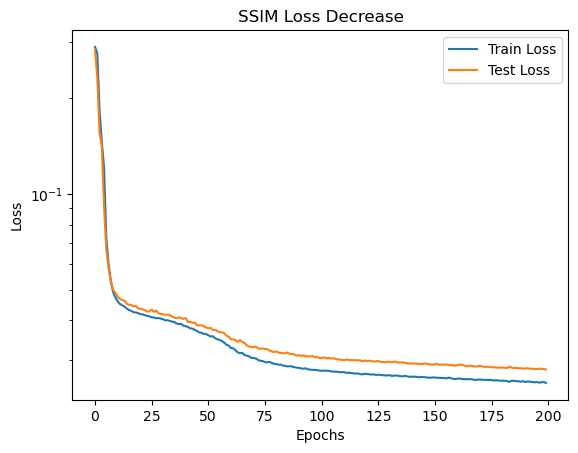

In [17]:
ax = pd.DataFrame({
    'Train Loss': [loss for loss in model_results['train_loss']],
    'Test Loss': [loss for loss in model_results['test_loss']]
}).plot(title='SSIM Loss Decrease', logy=True)

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

## Show Anomalies on Test Data

In [18]:
def load_model(model_name):
    """
    Function for loading saved models parameters. Neural network architecture should be the same as on saved model.
    
    Args:
        model_name (str): Name of the model to load
        
    Returns:
        loaded_model: A model instance with loaded parameters
    """
    model_path = Path("models")
    model_save_path = model_path / model_name

    loaded_model = autoencoder_v0()
    loaded_model.load_state_dict(torch.load(f=model_save_path))

    loaded_model = loaded_model.to(device)
    
    return loaded_model
    
model_name = "capsule_500x6x6_bottleneck_97.5acc.pth"
model_loaded = load_model(model_name)

Data transform block to fit input image in case of training the network on cropped images.

In [19]:
data_transform_test = transforms.Compose([
    transforms.Resize(size=(INPUT_CROP, INPUT_CROP)),
    transforms.Grayscale(1),
    transforms.ToTensor()
])

In [20]:
def image_reconstructed_plot(model: torch.nn.Module, 
                             image_path: str,  
                             transform=None,
                             device: torch.device = device):
    
    """ Plots image before and after passing through autoencoder, and SSIM contour """
    
    fig, ax = plt.subplots(1, 3)
    plt.gray()   
    
    img = Image.open(image_path)
    
    if transform:
        img_transformed = transform(img)

    model.to(device)
    model.eval()
    with torch.inference_mode():
        input_image = img_transformed.unsqueeze(dim=0).to(device)
        reconstructed = model(input_image)
    
    original = img_transformed.permute(1, 2, 0).cpu()
    
    defect = image_path.split("/")
    
    ax[0].imshow(original) 
    ax[0].set_title(f"{defect[3].capitalize()}")
    ax[0].axis("off")
    
    reconstructed = reconstructed.squeeze(0).permute(1, 2, 0).cpu()
    ax[1].imshow(reconstructed) 
    ax[1].set_title("Reconstructed")
    ax[1].axis("off")
    
    img_old = np.array(original.squeeze(2))
    img_new = np.array(reconstructed.squeeze(2))
    _, S = ski_ssim(img_old, img_new, full=True, channel_axis=False)

    ax[2].imshow(1-S, vmax = 1, cmap='jet') 
    ax[2].set_title("SSIM")
    ax[2].axis("off")

    plt.axis(False)

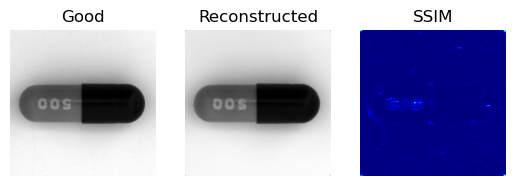

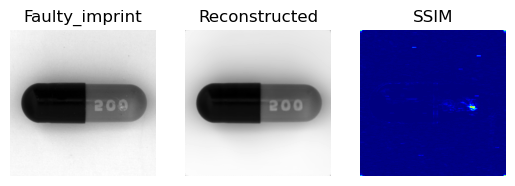

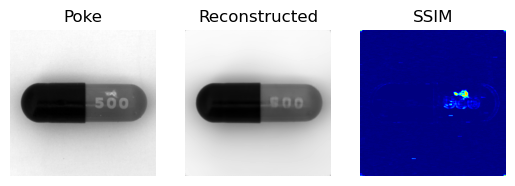

In [21]:
train_image_path = ("data/capsule/train/good/019.png")
test_image_path_1 = ("data/capsule/test/faulty_imprint/013.png")
test_image_path_2 = ("data/capsule/test/poke/011.png")

image_reconstructed_plot(model=model_loaded,
                        image_path=train_image_path,
                        transform=data_transform,
                        device=device)

image_reconstructed_plot(model=model_loaded,
                        image_path=test_image_path_1,
                        transform=data_transform,
                        device=device)

image_reconstructed_plot(model=model_loaded,
                        image_path=test_image_path_2,
                        transform=data_transform,
                        device=device)

## Save model

In [22]:
model_path = Path("models")
model_name = "capsule_500x6x6_bottleneck_97.5acc.pth"
model_save_path = model_path / model_name

print(f"Saving model to: {model_save_path}")

torch.save(obj=model.state_dict(), f=model_save_path)

Saving model to: models\capsule_500x6x6_bottleneck_97.5acc.pth
